In [4]:
import sys
from pathlib import Path
import ProbabilisticParcellation.functional_profiles as fp
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import ProbabilisticParcellation.functional_profiles as fp
import pandas as pd
import seaborn as sb
import ProbabilisticParcellation.scripts.atlas_paper.feature_model as fm
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit
import numpy as np
import os
import ProbabilisticParcellation.util as ut


## Tasks that differentiate between different cerebellar networks

In [5]:
Data, regions_all = fm.load_profiles()
tags = fm.load_features()
tags_individ = fm.subject_features(tags, Data)
task_matrix, task_codes = fm.task_indicator(Data)
tags_task = np.concatenate(
    (tags_individ.T.to_numpy(), task_matrix), axis=1)

Data_norm, tags_norm = fm.normalize(Data[regions_all], tags_task)

# Ridge regression
R2, features = ridgeFit(Data_norm.to_numpy(), tags_norm,
                        fit_intercept=False, voxel_wise=False, alpha=1.0)


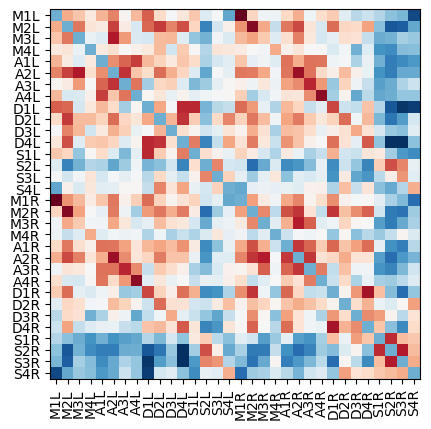

In [6]:
# Correlate profiles between subregions
# Select subregions
regions = regions_all
cmap = plt.get_cmap('RdBu_r')
corr = np.corrcoef(Data[regions].to_numpy().T)
# Set diagonal to zero
np.fill_diagonal(corr, 0)
plt.imshow(corr, cmap=cmap)
plt.xticks(np.arange(len(regions)), regions, rotation=90)
plt.yticks(np.arange(len(regions)), regions)
plt.savefig(ut.figure_dir + 'all_region_correlation.png', dpi=300)



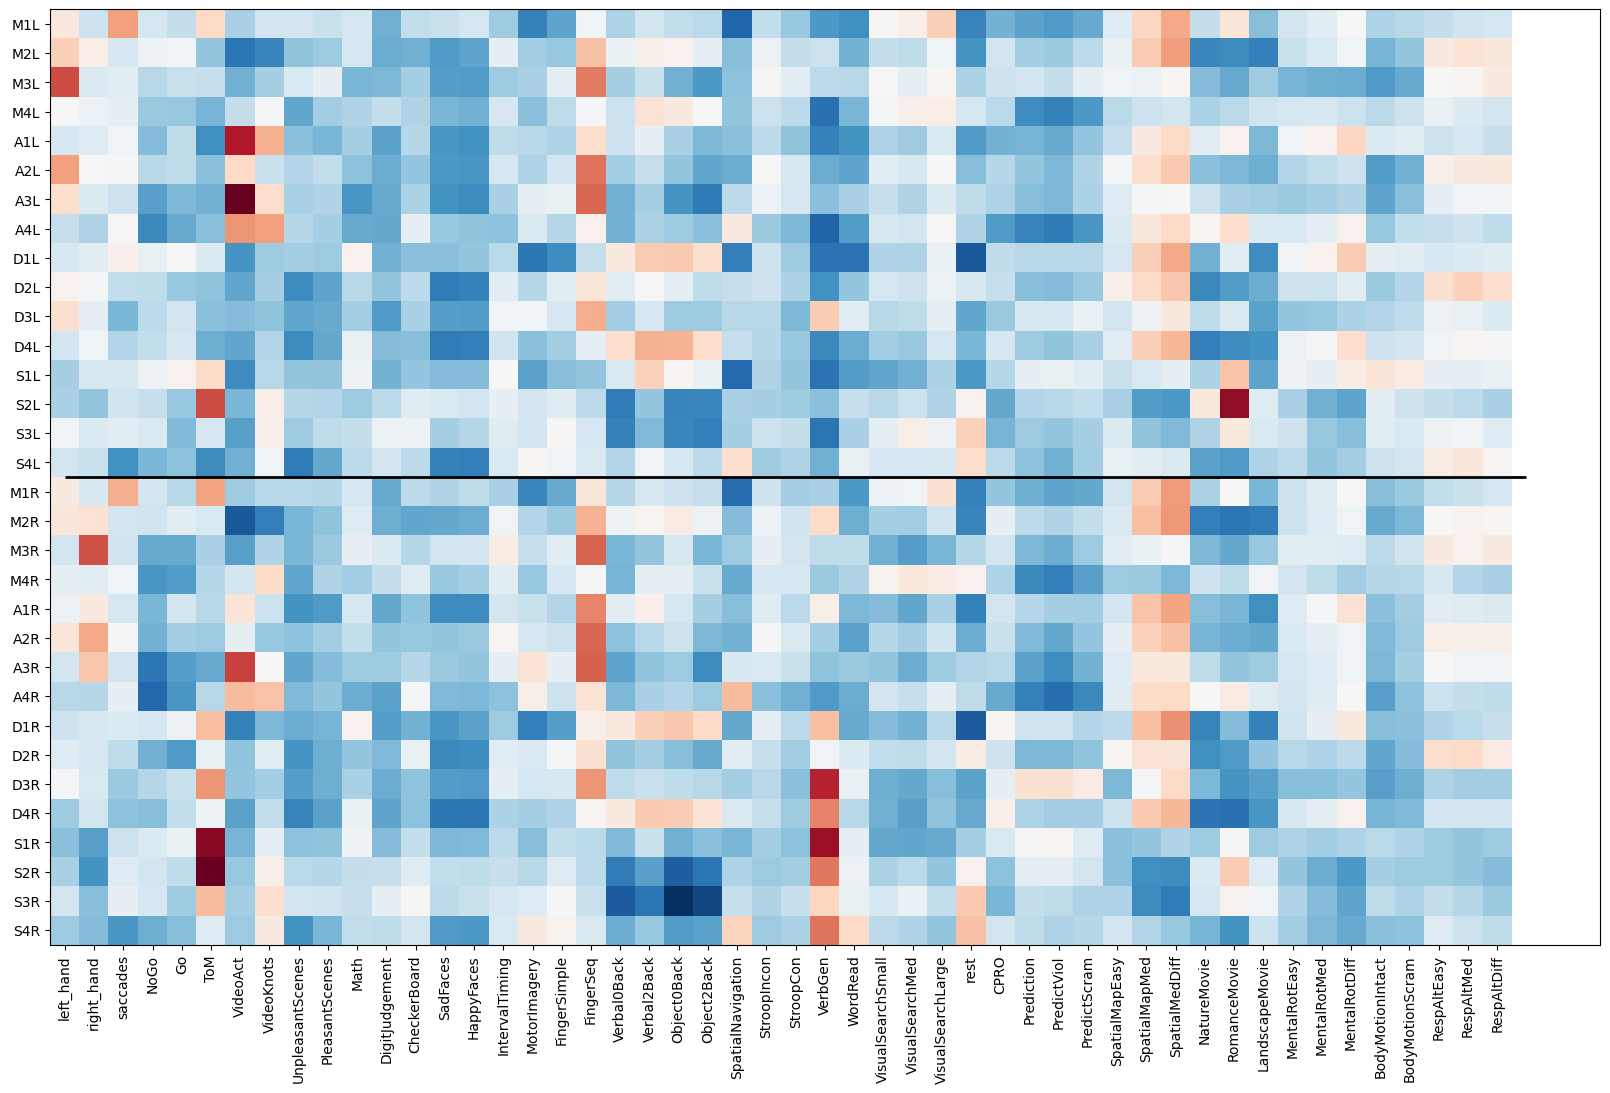

In [7]:
# Make dataframe
Features = pd.DataFrame(features.T, columns=[
    'left_hand', 'right_hand', 'saccades'] + list(task_codes.keys()), index=regions_all)

# Plot
cmap = plt.get_cmap('RdBu_r')
plt.figure(figsize=(20, 20))
plt.imshow(Features, cmap=cmap)
plt.yticks(np.arange(len(regions_all)), regions_all)
plt.xticks(np.arange(len(Features.columns.tolist())),
           Features.columns.tolist(), rotation=90)

# Plot a horizontal line in the middle
plt.hlines(len(regions_all) / 2 - 0.5, 0,
           len(Features.columns.tolist()), color='black', linewidth=2)
plt.savefig(f'{ut.figure_dir}/feature_matrix.png', dpi=300)


In [8]:
# Melt
Feature_regions = Features.loc[regions_all]
T = Feature_regions.reset_index().melt(id_vars='index', value_vars=Features.columns.tolist(),
                         var_name='task', value_name='score')

# make index into column
T['region'] = T['index']
# # Split region into side and region
T['side'] = T.region.str[-1]
T['reg'] = T.region.str[0:2]
T['net'] = T.region.str[0]


In [9]:
T

,index,task,score,region,side,reg,net
0,M1L,left_hand,0.130131,M1L,L,M1,M
1,M2L,left_hand,0.179132,M2L,L,M2,M
2,M3L,left_hand,0.330631,M3L,L,M3,M
3,M4L,left_hand,0.090430,M4L,L,M4,M
4,A1L,left_hand,0.029620,A1L,L,A1,A
...,...,...,...,...,...,...,...
1595,D4R,RespAltDiff,0.020860,D4R,R,D4,D
1596,S1R,RespAltDiff,-0.040205,S1R,R,S1,S
1597,S2R,RespAltDiff,-0.068355,S2R,R,S2,S
1598,S3R,RespAltDiff,-0.045576,S3R,R,S3,S


/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:120: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nume

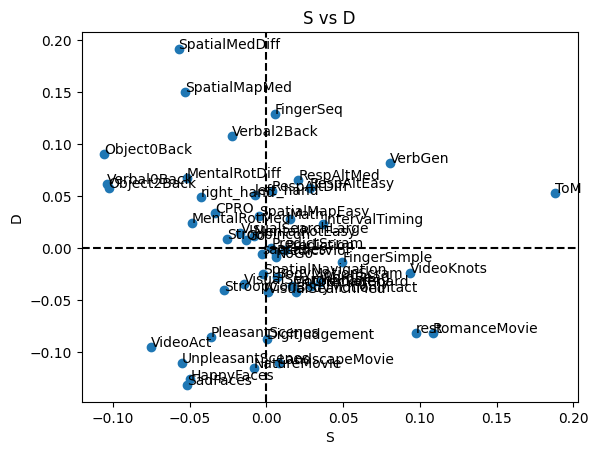

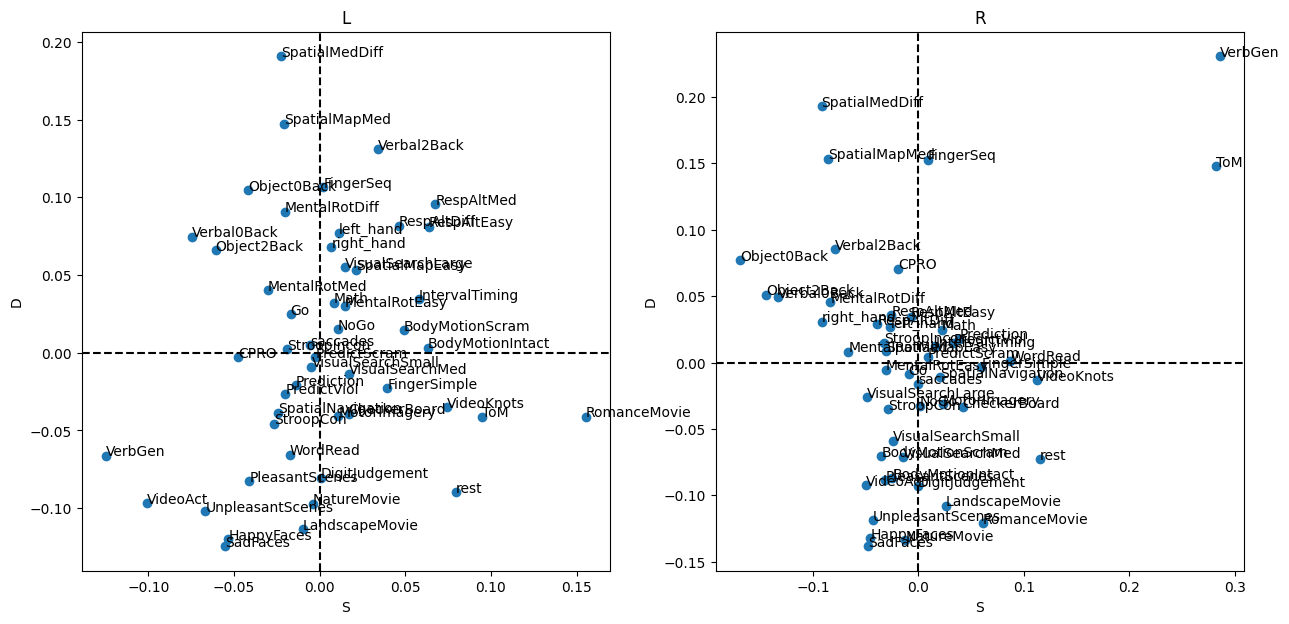

In [10]:
compare = ['S', 'D']
fm.scatter_plot(compare, T)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
fm.scatter_plot(compare, T, side='L')
plt.subplot(1, 2, 2)
fm.scatter_plot(compare, T, side='R')
plt.savefig(f'{ut.figure_dir}/feature_scatter_{compare[0]}_vs_{compare[1]}.png', dpi=300)

/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:120: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nume

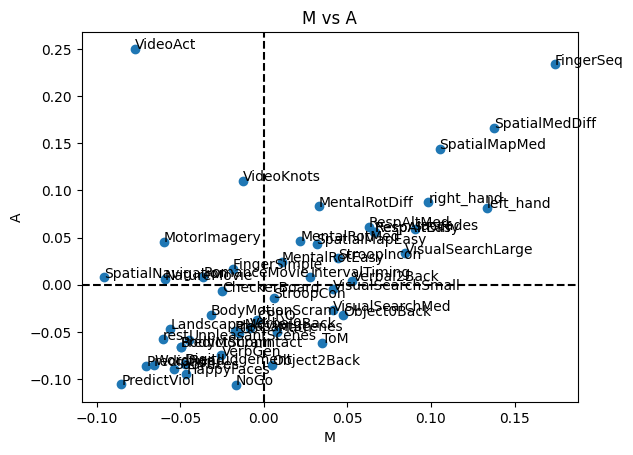

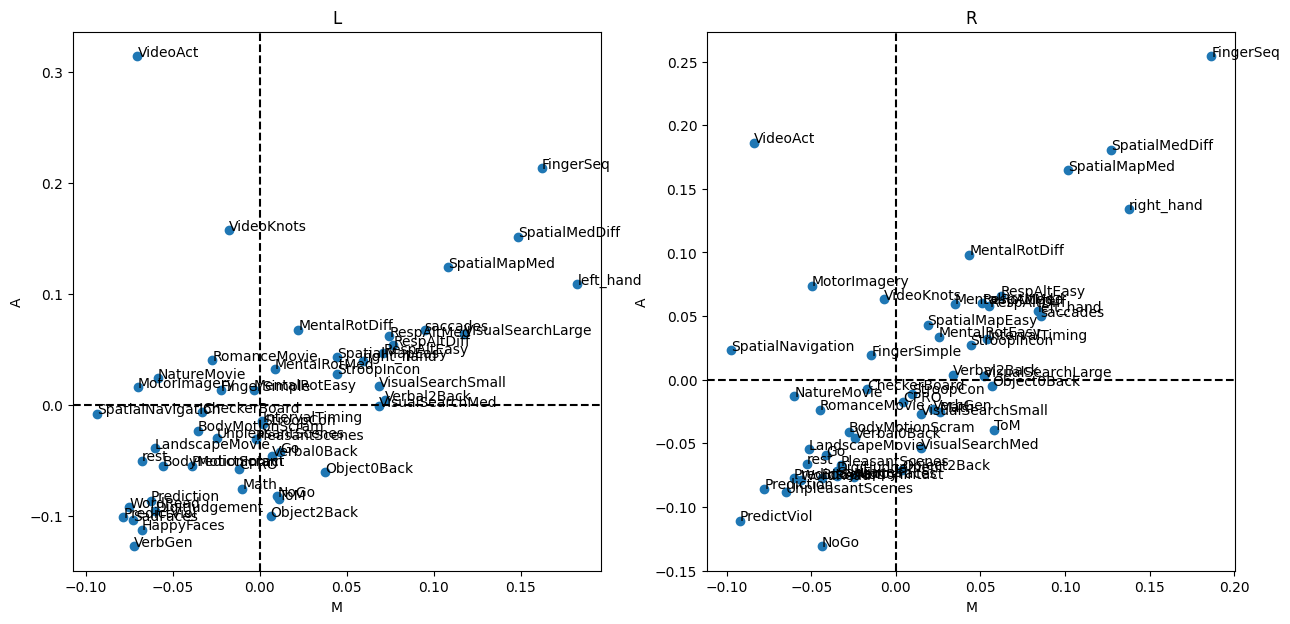

In [11]:
compare = ['M', 'A']
fm.scatter_plot(compare, T)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
fm.scatter_plot(compare, T, side='L')
plt.subplot(1, 2, 2)
fm.scatter_plot(compare, T, side='R')
plt.savefig(
    f'{ut.figure_dir}/feature_scatter_{compare[0]}_vs_{compare[1]}.png', dpi=300)


/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:120: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nume

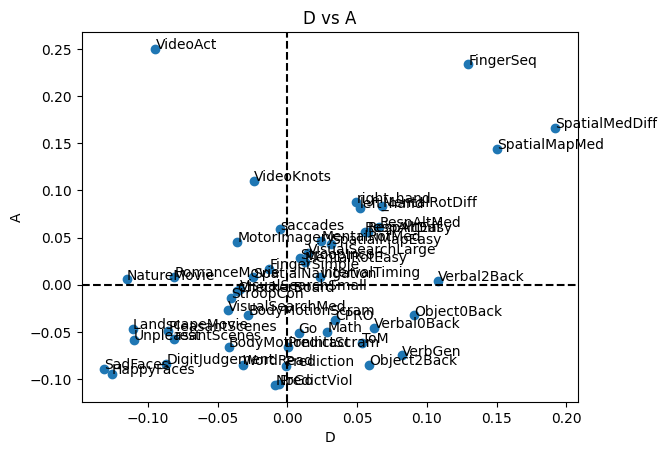

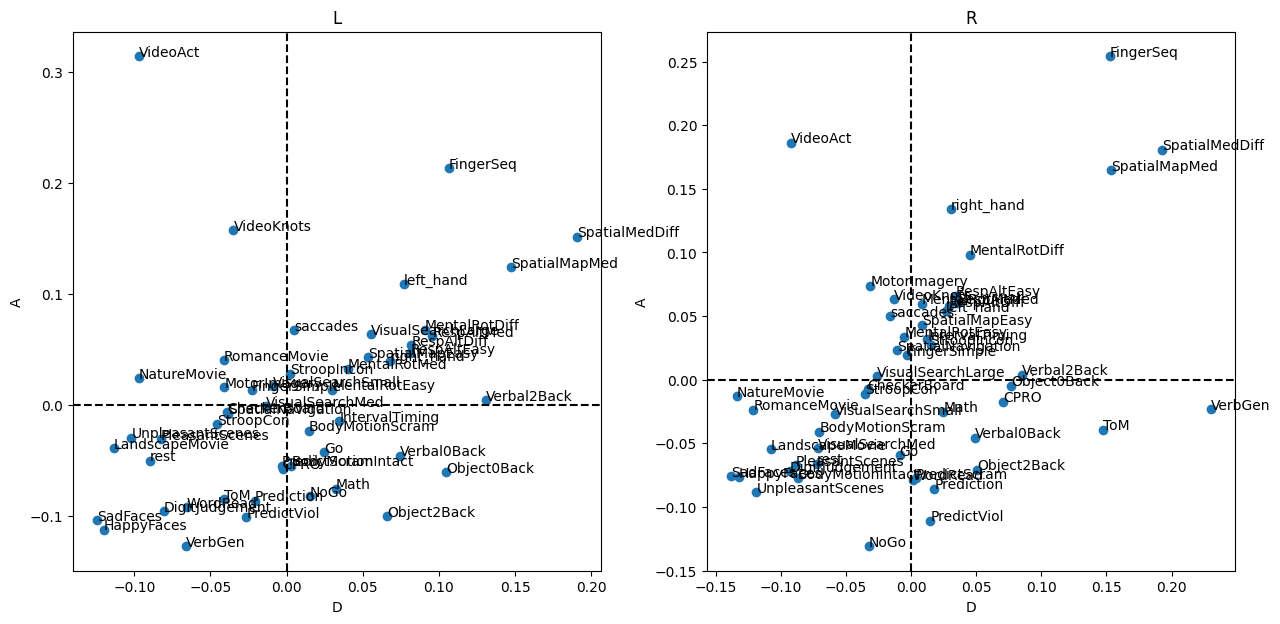

In [12]:
compare = ['D', 'A']
fm.scatter_plot(compare, T)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
fm.scatter_plot(compare, T, side='L')
plt.subplot(1, 2, 2)
fm.scatter_plot(compare, T, side='R')
plt.savefig(
    f'{ut.figure_dir}/feature_scatter_{compare[0]}_vs_{compare[1]}.png', dpi=300)


/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region1 = region1.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:120: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  region2 = region2.groupby(['task']).mean().reset_index()
/Users/callithrix/code/Python/ProbabilisticParcellation/scripts/atlas_paper/feature_model.py:119: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, nume

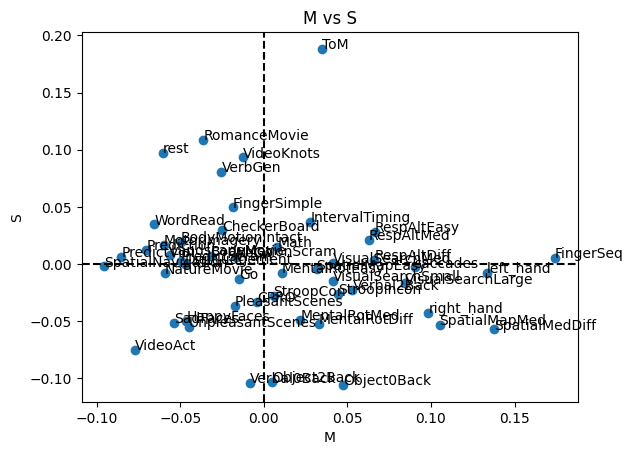

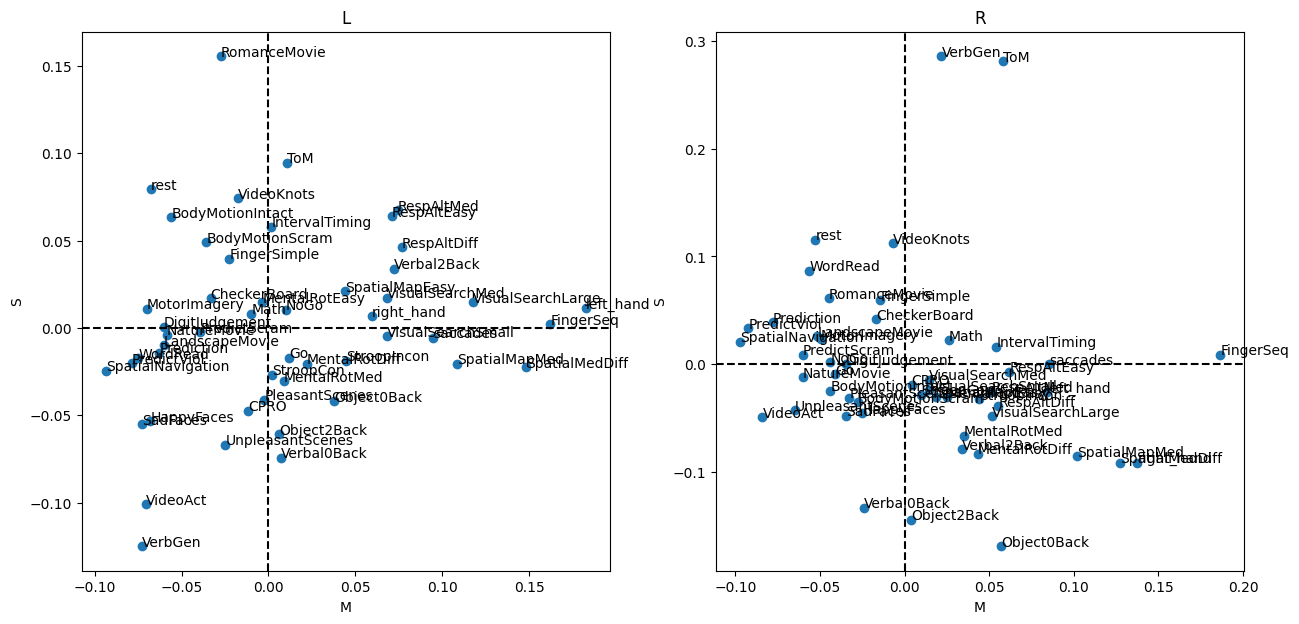

In [13]:
compare = ['M', 'S']
fm.scatter_plot(compare, T)
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
fm.scatter_plot(compare, T, side='L')
plt.subplot(1, 2, 2)
fm.scatter_plot(compare, T, side='R')
plt.savefig(
    f'{ut.figure_dir}/feature_scatter_{compare[0]}_vs_{compare[1]}.png', dpi=300)
